In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp
import csv
import datetime
import seaborn as sns
import time

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import catboost as cat
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

%matplotlib inline
sns.set()
import warnings
from tqdm import tqdm_notebook
import ipywidgets
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv('Train.csv', index_col=0)
X_test = pd.read_csv('Test.csv', index_col=0)
X_train.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
id,,,,,,,,,,,,,,,,,,,,,
0,2011-1,385,NaN,1,59,3,0,25.0,NaN,2,...,0,0,0,0,0,0,0,0,0,2489000
1,2011-1,247,NaN,5,53,2,1,15.0,1.0,2,...,0,0,0,0,0,0,0,0,0,1995000
2,2011-1,115,0.0,7,61,3,0,10.0,1.0,1,...,0,0,0,0,0,0,0,0,0,3993000
3,2011-1,491,1.0,5,61,3,1,30.0,NaN,0,...,0,0,0,0,0,0,0,0,0,5709000
4,2011-1,623,NaN,3,51,2,1,30.0,NaN,1,...,0,0,0,0,0,0,0,0,0,4374000


In [3]:
l_code = LabelEncoder()
X_train.date = l_code.fit_transform([i.split('-')[0] for i in X_train.date.tolist()])
X_test.date = l_code.fit_transform([i.split('-')[0] for i in X_test.date.tolist()])

In [4]:
def fill_features(data, feature, drop_features):
    index = data[data[feature].isna() == True].index
    y_train = data[data[feature].isna() == False][feature]
    x_train = data[data[feature].isna() == False].drop(drop_features, axis=1)
    x_test = data.loc[index].drop(drop_features, axis=1)
    forest = RandomForestClassifier(n_estimators=1000, max_depth=6, n_jobs=-1)
    forest.fit(x_train, y_train)
    y_pred = forest.predict(x_test)
    data.loc[index, feature] = y_pred
    return data[feature]

In [5]:
X_train['build_tech'] = fill_features(X_train, 'build_tech', ['price','g_lift', 'metro_dist', 'build_tech'])
X_train['metro_dist'] = fill_features(X_train, 'metro_dist', ['price','g_lift', 'metro_dist'])
X_train['g_lift'] = fill_features(X_train, 'g_lift', ['price', 'g_lift'])

In [6]:
X_test['build_tech'] = fill_features(X_test, 'build_tech', ['g_lift', 'metro_dist', 'build_tech'])
X_test['metro_dist'] = fill_features(X_test, 'metro_dist', ['g_lift', 'metro_dist'])
X_test['g_lift'] = fill_features(X_test, 'g_lift', ['g_lift'])

In [7]:
target = X_train.price
full_data = pd.concat([X_train.drop('price', axis=1), X_test], axis=0)

In [8]:
full_data.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
id,,,,,,,,,,,,,,,,,,,,,
0,0,385,0.0,1,59,3,0,25.0,0.0,2,...,0,0,0,0,0,0,0,0,0,0
1,0,247,1.0,5,53,2,1,15.0,1.0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,115,0.0,7,61,3,0,10.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,491,1.0,5,61,3,1,30.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,623,1.0,3,51,2,1,30.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
full_data = full_data.astype('int64').astype('category')
full_data = full_data.astype({'area': 'int64', 'rooms': 'int64', 'balcon': 'int64', 'n_photos': 'int64'})

In [10]:
X_train = pd.concat([full_data[:100000], target], axis=1)
X_test = full_data[len(target):]

<AxesSubplot:xlabel='price', ylabel='area'>

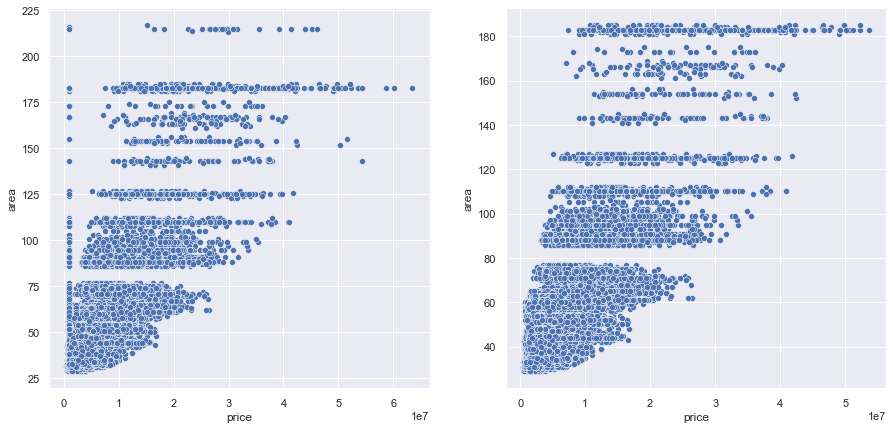

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.scatterplot(X_train.price, X_train.area, ax=ax[0])

min_flat_price = X_train[X_train['area'] > 200].price.min()
high_price = X_train[X_train.price > 5*10**7].price.sort_values()[::-1].values[4]
X_train = X_train.drop(X_train.index[X_train['price'] == min_flat_price], axis=0)
X_train = X_train.drop(X_train.index[X_train['area'] > 200], axis=0)
X_train = X_train.drop(X_train.index[X_train['price'] > high_price], axis=0)
X_train = X_train.drop(X_train.index[(X_train.rooms == 4) & (X_train['price'] > 5*10**7)], axis=0)
sns.scatterplot(X_train.price, X_train.area, ax=ax[1])

<AxesSubplot:xlabel='price', ylabel='street_id'>

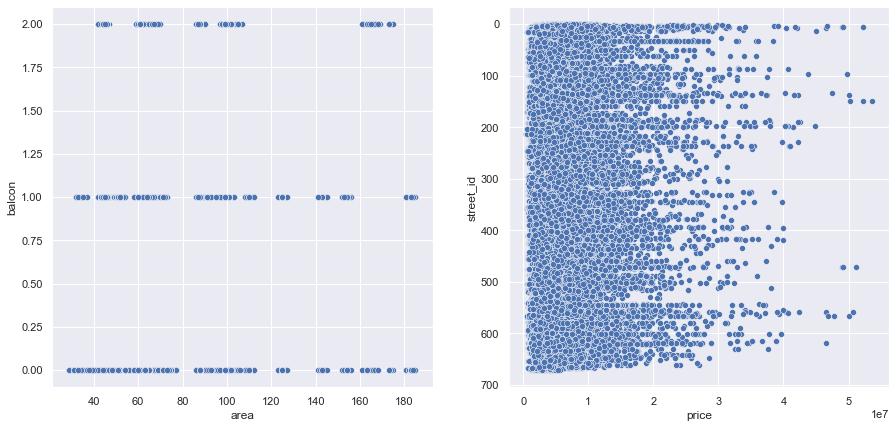

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.scatterplot(X_train.area, X_train.balcon, ax=ax[0])
sns.scatterplot(X_train.price, X_train.street_id, ax=ax[1])

<AxesSubplot:xlabel='price', ylabel='metro_dist'>

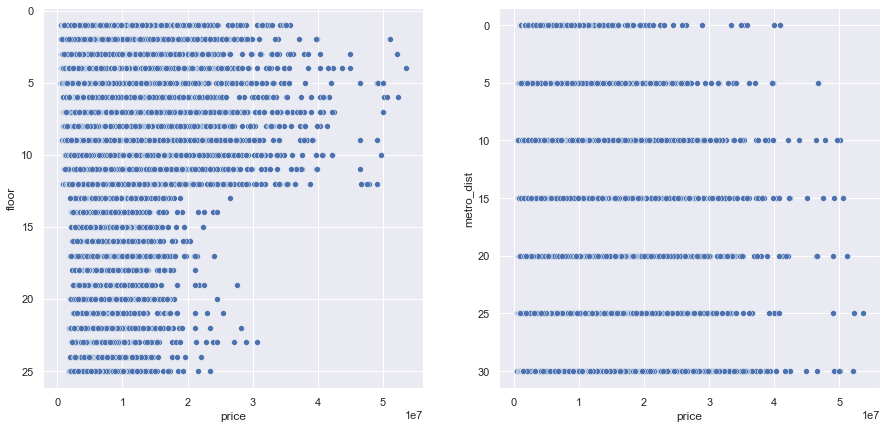

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.scatterplot(X_train.price, X_train.floor, ax=ax[0])
sns.scatterplot(X_train.price, X_train.metro_dist, ax=ax[1])

<AxesSubplot:>

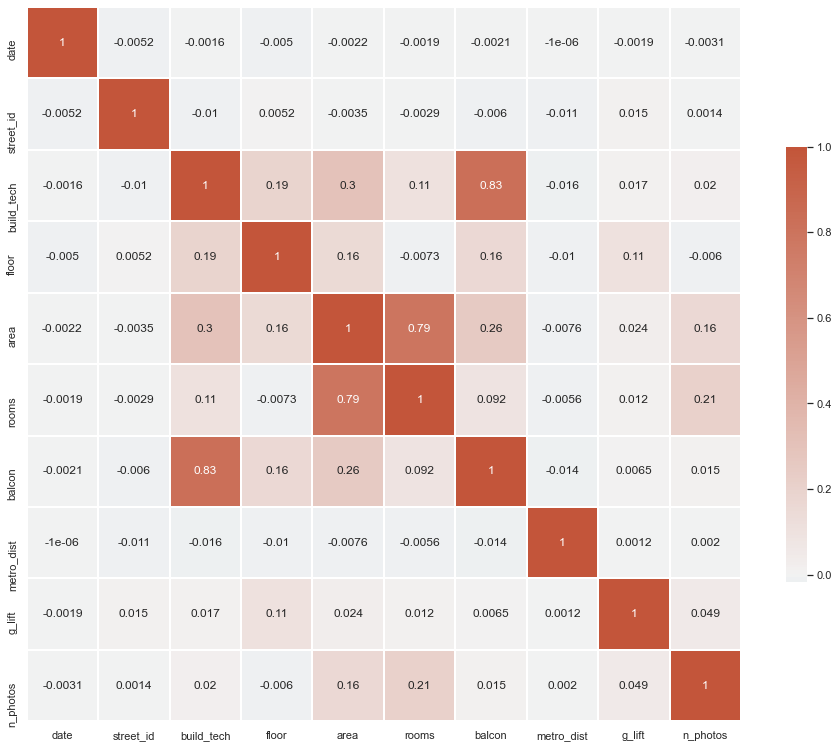

In [14]:
plt.figure(figsize=(16,16))
corr = X_train.loc[:,'date':'n_photos'].astype('int64').corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True)

In [15]:
target = X_train.price
X_train = X_train.drop('price', axis=1)

In [16]:
def metrics_scores(true, predict):
    return mean_absolute_error(true, predict), r2_score(true, predict)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X_train, target, test_size=0.2, random_state=42)

In [18]:
categorial_features = X_train.select_dtypes(include='category').columns.tolist()

In [19]:
cat_boost = cat.CatBoostRegressor(random_seed=42, max_depth=11, cat_features=categorial_features, verbose=0)
cat_boost.fit(x_train, y_train)
cat_boost_answer = cat_boost.predict(x_test)

In [20]:
xg_boost = xgb.XGBRegressor(n_estimators=800, max_depth=7, n_jobs=-1, random_state=42, eta=0.23, reg_lambda=0.5)
xg_boost.fit(x_train.astype('int64'), y_train)
xg_boost_answer = xg_boost.predict(x_test.astype('int64'))

In [21]:
light_gbm = lgb.LGBMRegressor(n_estimators=400, max_depth=16, n_jobs=-1, random_state=42, categorical_feature=categorial_features)
light_gbm.fit(x_train, y_train)
light_gbm_answer = light_gbm.predict(x_test)

In [22]:
results_dict = {
    'cat_boost': metrics_scores(y_test, cat_boost_answer),
    'light_gbm': metrics_scores(y_test, light_gbm_answer),
    'xg_boost': metrics_scores(y_test, xg_boost_answer)
}
metrics_data = pd.DataFrame(data=results_dict, index=['MAE', 'R^2'])
metrics_data

,cat_boost,light_gbm,xg_boost
MAE,421397.477884,423266.860999,485878.290751
R^2,0.968148,0.966788,0.950252


<AxesSubplot:xlabel='price', ylabel='Density'>

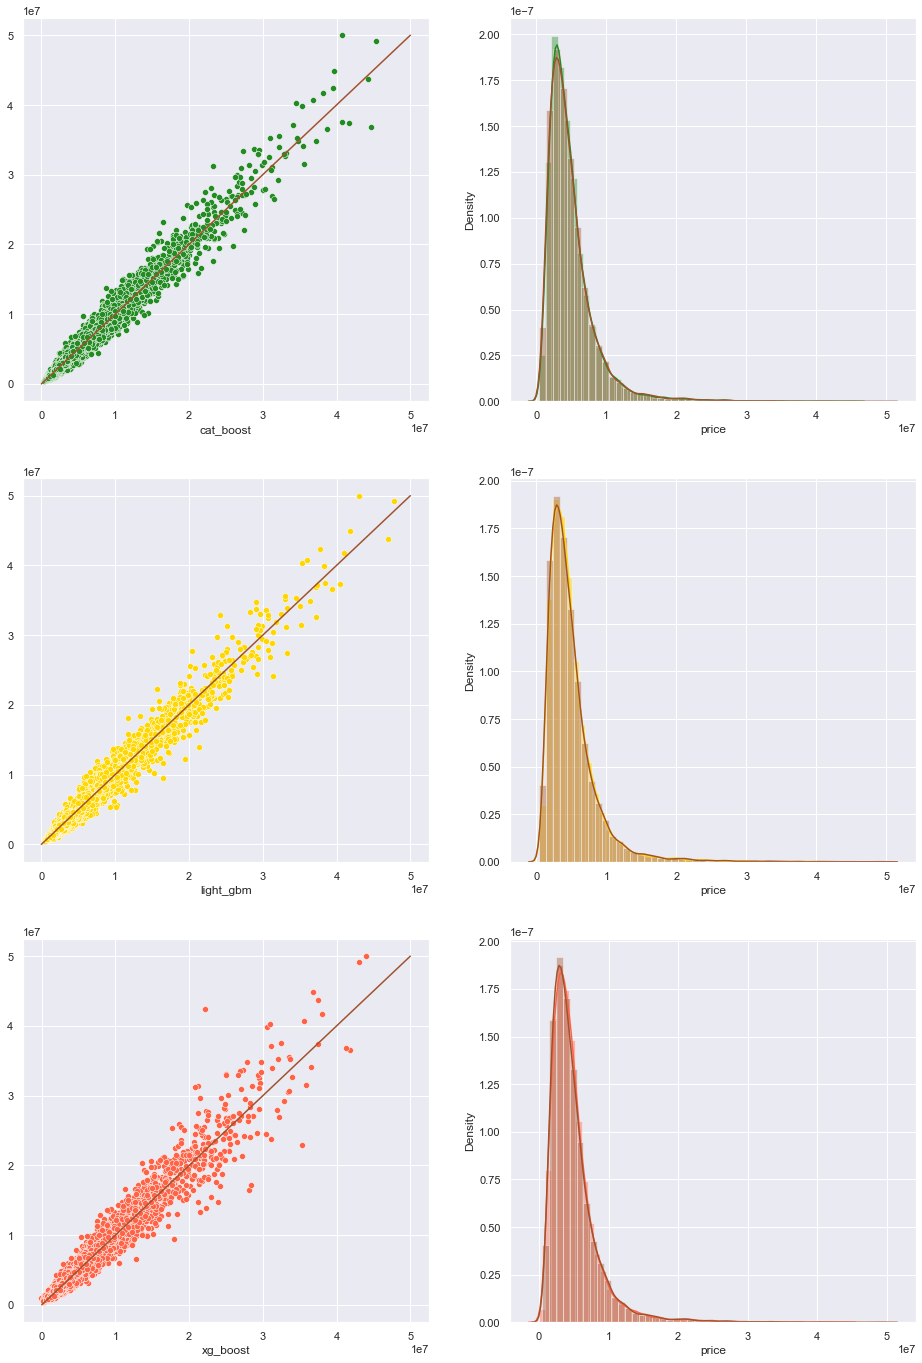

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(16,24))

sns.lineplot([0, 5*10**7], [0,5*10**7], ax=axs[0,0], color='sienna')
sns.scatterplot(pd.Series(cat_boost_answer, name='cat_boost'), y_test.values, ax=axs[0,0], color='forestgreen')
sns.distplot(cat_boost_answer, ax=axs[0,1], color='forestgreen')
sns.distplot(y_test, ax=axs[0,1], color='sienna')


sns.lineplot([0, 5*10**7], [0,5*10**7], ax=axs[1,0], color='sienna')
sns.scatterplot(pd.Series(light_gbm_answer, name='light_gbm'), y_test.values, ax=axs[1,0], color='gold')
sns.distplot(light_gbm_answer, ax=axs[1,1], color='gold')
sns.distplot(y_test, ax=axs[1,1], color='sienna')

sns.lineplot([0, 5*10**7], [0,5*10**7], ax=axs[2,0], color='sienna')
sns.scatterplot(pd.Series(xg_boost_answer, name='xg_boost'), y_test.values, ax=axs[2,0], color='tomato')
sns.distplot(xg_boost_answer, ax=axs[2,1], color='tomato')
sns.distplot(y_test, ax=axs[2,1], color='sienna')

In [24]:
feature_cat_boost = cat_boost.predict(X_test)
feature_light_gbm = light_gbm.predict(X_test)
feature_xg_boost = xg_boost.predict(X_test.astype('int64'))

In [25]:
def train_test_dataset_stacking(train, test):
    
    train.insert(train.shape[1], 'xg_boost', np.round(xg_boost_answer))
    train.insert(train.shape[1], 'light_gbm', np.round(light_gbm_answer))
    train.insert(train.shape[1], 'cat_boost', np.round(cat_boost_answer))
    train.insert(train.shape[1], 'price', y_test)
    
    test.insert(test.shape[1], 'xg_boost', np.round(feature_xg_boost))
    test.insert(test.shape[1], 'light_gbm', np.round(feature_light_gbm))
    test.insert(test.shape[1], 'cat_boost', np.round(feature_cat_boost))
    
    return train.drop('price', axis=1), train.price, test

In [26]:
stacking_train, stacking_target, stacking_test = train_test_dataset_stacking(x_test.copy(), X_test.copy()) 

In [27]:
categorial_features = stacking_train.select_dtypes(include='category').columns.tolist()
cat_boost = cat.CatBoostRegressor(random_seed=42, max_depth=11, cat_features=categorial_features, verbose=0)
cat_boost.fit(stacking_train, stacking_target)
ensemble_stacking_answer = cat_boost.predict(stacking_test)

In [28]:
SampleSubmission = pd.read_csv('SampleSubmission.csv', index_col=0)
SampleSubmission.price = np.round(ensemble_stacking_answer, 2)
SampleSubmission.to_csv('SampleSubmission.csv')
SampleSubmission.head(10)

,price
id,
100000,1876486.62
100001,2353646.68
100002,5634665.90
100003,1332271.88
100004,6686450.22
100005,4903432.51
100006,4591589.56
100007,5369877.81
100008,2663019.98
